In [31]:
#Packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, glob

from sklearn import preprocessing


## Load and Manipulate Data

### Load the data

### Franklin's work starts below

In [32]:
#Load the census data
census_dat = pd.read_csv('./data/Census_Data_Cleaned.csv', dtype = 'str')

#Load the hospital beds data
beds_dat = pd.read_csv('./data/hospital_beds_data.csv', dtype = 'str')

#Load the cases data
cases_nyc = pd.read_csv('./zcta-history/2020-04-01.csv', dtype = 'str')

cases_nyc_0407 = pd.read_csv('./zcta-history/2020-04-07.csv', dtype = 'str')
cases_nyc_0414 = pd.read_csv('./zcta-history/2020-04-14.csv', dtype = 'str')
cases_nyc_0421 = pd.read_csv('./zcta-history/2020-04-21.csv', dtype = 'str')
cases_nyc_0428 = pd.read_csv('./zcta-history/2020-04-28.csv', dtype = 'str')

In [33]:
cases_nyc = cases_nyc.rename(columns={"Positive": "Positive_0401", "Total": "Total_0401", 
                                      "zcta_cum.perc_pos":"zcta_cum_perc_pos_0401"})

cases_nyc_0407 = cases_nyc_0407.rename(columns={"Positive": "Positive_0407", "Total": "Total_0407", 
                                      "zcta_cum.perc_pos":"zcta_cum_perc_pos_0407"})

# cases_nyc_0414 = cases_nyc_0414.rename(columns={"Positive": "Positive_0414", "Total": "Total_0414", 
#                                      "zcta_cum.perc_pos":"zcta_cum_perc_pos_0414"})

# cases_nyc_0421 = cases_nyc_0421.rename(columns={"Positive": "Positive_0421", "Total": "Total_0421", 
#                                      "zcta_cum.perc_pos":"zcta_cum_perc_pos_0421"})

# cases_nyc_0428 = cases_nyc_0428.rename(columns={"Positive": "Positive_0428", "Total": "Total_0428", 
#                                      "zcta_cum.perc_pos":"zcta_cum_perc_pos_0428"})

In [34]:
#Join together all the weekly cases data
cases_nyc = cases_nyc.merge(cases_nyc_0407, how = 'left', left_on = 'MODZCTA', right_on = 'MODZCTA')
# cases_nyc = cases_nyc.merge(cases_nyc_0414, how = 'left', left_on = 'MODZCTA', right_on = 'MODZCTA')
# cases_nyc = cases_nyc.merge(cases_nyc_0421, how = 'left', left_on = 'MODZCTA', right_on = 'MODZCTA')
# cases_nyc = cases_nyc.merge(cases_nyc_0428, how = 'left', left_on = 'MODZCTA', right_on = 'MODZCTA')

In [35]:
#Join all the values together
data = cases_nyc.merge(census_dat, how = 'left', left_on = 'MODZCTA', right_on = 'zip_code_tabulation_area')
data = data.merge(beds_dat, how = 'left', left_on = 'MODZCTA', right_on = 'zip')

data["beds"] = data["beds"].fillna(0)

In [36]:
#Remove the first record (no zip)
data = data[1:]

#Remove the zip code columns
data = data.loc[:, data.columns != 'zip_code_tabulation_area']
data = data.loc[:, data.columns != 'zip']

In [37]:
#Cast the rest of the columns as float
for col in data.columns:
    if col == "MODZCTA":
        continue 
    else:
        data.loc[:,col] = data.loc[:,col].astype(float)
        
#Divide by 100 for percents
# data.loc[:,"zcta_cum_perc_pos_0401"] = data.loc[:,"zcta_cum_perc_pos_0401"]/100.0
data.loc[:,"zcta_cum_perc_pos_0407"] = data.loc[:,"zcta_cum_perc_pos_0407"]/100.0
# data.loc[:,"zcta_cum_perc_pos_0414"] = data.loc[:,"zcta_cum_perc_pos_0414"]/100.0
# data.loc[:,"zcta_cum_perc_pos_0421"] = data.loc[:,"zcta_cum_perc_pos_0421"]/100.0
# data.loc[:,"zcta_cum_perc_pos_0428"] = data.loc[:,"zcta_cum_perc_pos_0428"]/100.0


In [38]:
#Exclude columns with > 10 nulls
data = data.drop(['med_value','avg_hoursworked','med_contractrent',
                  'avg_income_deficit_pastyear','med_age_marriage'], axis = 1)

In [39]:
#Impute values for columsn with < 10 nulls
#data["beds"] = data["beds"].fillna(0)
for col in data.columns:
    data[col] = data[col].fillna(data[col].mean())

In [40]:
#Check we've removed them all:
data.isnull().sum(axis = 0).sort_values().tail() #0. good.

perc_transport_to_work_walk      0
perc_transport_to_work_bike      0
perc_transport_to_work_public    0
perc_leave_for_work_530to559     0
beds                             0
dtype: int64

In [41]:
#Percent Columns
cols = [col for col in data.columns if 'perc' in col]

for col in cols:
    data.loc[data[col] > 1, col] = 1

In [42]:
#Number of cases per capita - continuous
cases_per_10k = data[["MODZCTA", "Positive_0407", 'pop_total']]

cases_per_10k.loc[:,"cases_per_10k_0407"] = 10000 * cases_per_10k.loc[:,"Positive_0407"] / \
    cases_per_10k.loc[:,"pop_total"]

y_categorical_0407 = np.zeros(len(cases_per_10k.cases_per_10k_0407))
y_categorical_0407 = y_categorical_0407.astype(str)

#Low
y_categorical_0407[cases_per_10k.cases_per_10k_0407 <= 75] = "Low"
#High
y_categorical_0407[cases_per_10k.cases_per_10k_0407 > 75] = "High"

pd.DataFrame(y_categorical_0407, columns = ['y']).groupby('y').size()

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


y
High    99
Low     78
dtype: int64

In [43]:
data = data.merge(cases_per_10k, how = 'left', left_on = 'MODZCTA', right_on = 'MODZCTA')

In [44]:
hi_data = data[data['cases_per_10k_0407'] > 75]
low_data = data[data['cases_per_10k_0407'] <= 75]

In [45]:
print(hi_data.shape) # 80 training
print(low_data.shape) # 62 training
# hi_data.head()

(99, 87)
(78, 87)


In [46]:
DROP_COLUMNS = ['Positive_0401', 'Total_0401', 'Positive_0407_x', 'Total_0407', 'zcta_cum_perc_pos_0407', 'cases_per_10k_0407', 'Positive_0407_y', 'pop_total_y', 'pop_total_x']

train_data = low_data[:62]
train_y = train_data['cases_per_10k_0407']
train_data = train_data.drop(DROP_COLUMNS, axis=1)

test_data = low_data[62:]
test_y = test_data['cases_per_10k_0407']
test_data = test_data.drop(DROP_COLUMNS, axis=1)

scale_data = low_data
scale_data = scale_data.drop(DROP_COLUMNS, axis=1)

## Normalize

In [47]:
#Set the scaler
scaler = preprocessing.StandardScaler().fit(scale_data)
#Scale train/test data
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

## Plot regularization path

In [48]:

from sklearn import linear_model
import itertools

eps = 0.0001
alphas_lasso, coefs_lasso, _ = linear_model.enet_path(
    train_data, train_y,n_alphas=10000, eps=eps, l1_ratio=1., fit_intercept=False)

In [49]:
cols = low_data
data_columns = cols.drop(DROP_COLUMNS, axis=1).columns

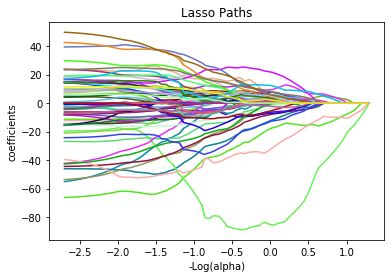

In [62]:
# Plot the regularization paths:
# Display results

# make legend small ==
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')
# make legend small ==

plt.figure(1)
colors = itertools.cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_lasso = np.log10(alphas_lasso)
i = 0
for coef_l, c in zip(coefs_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=np.random.rand(3,), label=data_columns[i])
    i += 1

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso Paths')
plt.axis('tight')
# plt.legend(prop=fontP)
plt.show()

### gridsearch to find optimal alpha

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

lasso = Lasso(random_state=0, max_iter=1000)
alphas = np.logspace(-1.5, 3, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(train_data, train_y)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.668744080605713, tolerance: 0.5195095142870195
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.284660797930655, tolerance: 0.7174706377965137
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9297010799960574, tolerance: 0.5894751438716854
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.2102

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=0,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([3.16227766e-02, 4.52035366e-02, 6.46167079e-02, 9.23670857e-02,
       1.32035178e-01, 1....
       2.30180731e+00, 3.29034456e+00, 4.70342034e+00, 6.72335754e+00,
       9.61077966e+00, 1.37382380e+01, 1.96382800e+01, 2.80721620e+01,
       4.01280703e+01, 5.73615251e+01, 8.19960824e+01, 1.17210230e+02,
       1.67547492e+02, 2.39502662e+02, 3.42359796e+02, 4.89390092e+02,
       6.99564216e+02, 1.00000000e+03])}],
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring=None, verbose=0)

In [52]:
print('best regularization param:', clf.best_params_['alpha'])
alpha = clf.best_params_['alpha']

best regularization param: 2.3018073130224677


### step 3. train lasso


In [59]:
from sklearn.linear_model import ElasticNet
lasso_model = ElasticNet(alpha=alpha, l1_ratio=1)
lasso_model.fit(train_data, train_y)

ElasticNet(alpha=2.3018073130224677, copy_X=True, fit_intercept=True,
           l1_ratio=1, max_iter=1000, normalize=False, positive=False,
           precompute=False, random_state=None, selection='cyclic', tol=0.0001,
           warm_start=False)

### step 4. pull out nonzero columns

In [60]:
for col, val in zip(data_columns, lasso_model.coef_.tolist()):
    if val != 0:
        print(col, end=",\n")

pop_perc_some_college,
perc_leave_for_work_8to829,
perc_with_Supplemental_Security_Income_cash_public_assistance_income_or_Food_Stamps_SNAP,
perc_SSI,


In [61]:
lasso_model.score(test_data, test_y)

-0.1729637434509359